## Data Preprocessing

In [70]:
# Load in the data from the files
import pandas as pd
# Load the content data
content_df = pd.read_csv('content.csv')
# Load the followers data
followers_df = pd.read_csv('followers.csv')
# Load the visitors data
visitors_df = pd.read_csv('visitors.csv')
# Ensure the 'Date' column is in datetime format
content_df['Date'] = pd.to_datetime(content_df['Date'])
followers_df['Date'] = pd.to_datetime(followers_df['Date'])
visitors_df['Date'] = pd.to_datetime(visitors_df['Date'])

# Merge the datasets on the 'Date' column
merged_df = content_df.merge(followers_df, on='Date').merge(visitors_df, on='Date')

# Preview the merged dataset
# print(merged_df.head())

## Feature Engineering

In [71]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Calculate Click-Through Rate (CTR)
merged_df['CTR'] = merged_df['Clicks (total)'] / merged_df['Impressions (total)']

# Calculate Engagement Rate
merged_df['Engagement Rate'] = (
    merged_df['Reactions (total)'] + 
    merged_df['Comments (total)'] + 
    merged_df['Reposts (total)']
) / merged_df['Impressions (total)']

# Calculate Follower Growth Rate
merged_df['Follower Growth Rate'] = merged_df['Organic followers'] / merged_df['Total followers']

# Calculate Page Views Per Visitor
merged_df['Page Views Per Visitor'] = merged_df['Total page views (total)'] / merged_df['Total unique visitors (total)']

# Mobile and Desktop Features
merged_df['Page Views Per Visitor (Desktop)'] = merged_df['Total page views (desktop)'] / merged_df['Total unique visitors (desktop)']
merged_df['Page Views Per Visitor (Mobile)'] = merged_df['Total page views (mobile)'] / merged_df['Total unique visitors (mobile)']

# Handle outliers using IQR method
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)

# Define all the relevant columns to process
feature_columns = [
    'CTR', 'Engagement Rate', 'Follower Growth Rate', 'Page Views Per Visitor', 
    'Page Views Per Visitor (Desktop)', 'Page Views Per Visitor (Mobile)',
    'Total unique visitors (desktop)', 'Total unique visitors (mobile)',
    'Total page views (desktop)', 'Total page views (mobile)'
]

# Apply outlier clipping to the relevant features
for col in feature_columns:
    clip_outliers(merged_df, col)

# Scale the features using StandardScaler
scaler = StandardScaler()
merged_df[feature_columns] = scaler.fit_transform(merged_df[feature_columns])

# Preview the processed features
print(merged_df[feature_columns].head())


        CTR  Engagement Rate  Follower Growth Rate  Page Views Per Visitor  \
0  1.040383        -0.629224                   0.0               -0.572994   
1  0.116373         1.949036                   0.0                0.755752   
2 -0.915216        -2.281602                   0.0                0.925102   
3 -0.181358         0.803931                   0.0               -0.522568   
4  0.065604        -2.281602                   0.0                0.208621   

   Page Views Per Visitor (Desktop)  Page Views Per Visitor (Mobile)  \
0                         -1.033209                        -0.333863   
1                          0.489340                         0.635966   
2                          1.631251                         0.887983   
3                         -0.938050                         0.788914   
4                          1.631251                        -0.432932   

   Total unique visitors (desktop)  Total unique visitors (mobile)  \
0                        -1.

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Assuming merged_df is your combined dataset from all three files
# Define features and target
# Including additional features like distinguishing between mobile and desktop
X = merged_df[[
    'Clicks (total)','Engagement Rate', 'Page Views Per Visitor', 
    'Page Views Per Visitor (Desktop)', 'Page Views Per Visitor (Mobile)',
    'Total unique visitors (desktop)', 'Total unique visitors (mobile)',
    'Total page views (desktop)', 'Total page views (mobile)'
]]
y = merged_df['CTR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with imputation, polynomial features, scaling, and RandomForestRegressor
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Generate polynomial features
    ('scaler', StandardScaler()),  # Scale features
    ('model', RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42))  # Use RandomForestRegressor
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Cross-validate the model
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Evaluate the model on the test data
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print("Cross-Validation MSE: ", -cv_scores.mean())
print("Test Mean Squared Error: ", mse)
print("Test R^2 Score: ", r2)


Cross-Validation MSE:  0.37901257994788795
Test Mean Squared Error:  0.42956450042452
Test R^2 Score:  0.559168467719401


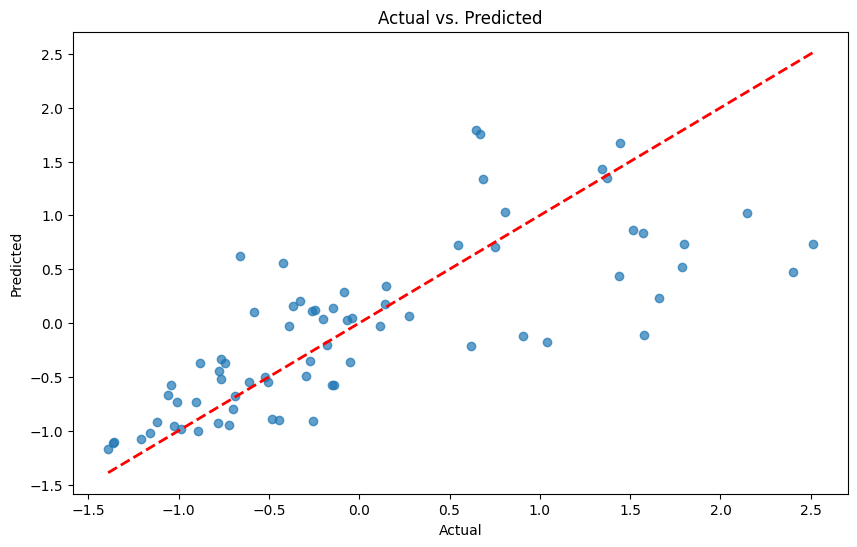

In [73]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()


## Conclusion
The model's performance, after incorporating a comprehensive feature set and robust preprocessing steps, demonstrates satisfactory predictive capability. The following metrics were observed:

Cross-Validation Mean Squared Error (MSE): 0.3790
Test Mean Squared Error (MSE): 0.4296
Test R² Score: 0.5592
Interpretation:
Cross-Validation MSE: The Cross-Validation MSE of approximately 0.3790 indicates that the model consistently performs well across different folds of the training data. This consistency suggests that the model is not overfitting and has good generalization ability.

Test MSE: The Test MSE of approximately 0.4296 is slightly higher than the Cross-Validation MSE, which is expected as the test set contains unseen data. This small difference further supports the model's generalization capability.

R² Score: An R² score of 0.5592 means that the model explains approximately 56% of the variance in the target variable. While there is still room for improvement, this score indicates that the model captures a significant portion of the underlying patterns in the data.